<a href="https://colab.research.google.com/github/MysticalHeat/python_labs/blob/main/%D0%9B%D0%B0%D0%B1_4_%D0%9B%D0%B8%D0%BD%D0%B5%D0%B9%D0%BD%D0%B0%D1%8F_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D1%8F_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Базовая регрессия: прогнозирование топливной эффективности

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/regression"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

В задаче *регрессии* цель состоит в том, чтобы спрогнозировать результат непрерывной величины, такой как цена или вероятность. Сравните это с задачей *классификации*, целью которой является выбор класса из списка классов (например, когда изображение содержит яблоко или апельсин, чтобы распознать, какой фрукт изображен на изображении).

В этом руководстве используется классический набор данных [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) и демонстрируется, как строить модели для прогнозирования топливной эффективности конца 1970-х и начала 1980-х годов. автомобили. Для этого вы снабдите модели описанием многих автомобилей того периода времени. Это описание включает в себя такие атрибуты, как цилиндры, рабочий объем, мощность и вес.


In [57]:
# Use seaborn for pairplot.
!pip install -q seaborn

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [59]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.18.0


## Набор данных Auto MPG

Набор данных доступен в [репозитории машинного обучения UCI] (https://archive.ics.uci.edu/ml/).


### Получить данные
Сначала загрузите и импортируйте набор данных с помощью pandas:

In [60]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [61]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### Очистка данных

Набор данных содержит несколько неизвестных значений:

In [62]:
dataset.isna().sum()

,0
MPG,0
Cylinders,0
Displacement,0
Horsepower,6
Weight,0
Acceleration,0
Model Year,0
Origin,0


Оставьте эти строки, чтобы упростить начальный урок:

In [63]:
dataset = dataset.dropna()

Столбец «Происхождение» является категориальным, а не числовым. Итак, следующим шагом будет горячее кодирование значений в столбце с помощью [pd.get_dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html).



In [64]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [65]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,False,False,True
394,44.0,4,97.0,52.0,2130.0,24.6,82,True,False,False
395,32.0,4,135.0,84.0,2295.0,11.6,82,False,False,True
396,28.0,4,120.0,79.0,2625.0,18.6,82,False,False,True
397,31.0,4,119.0,82.0,2720.0,19.4,82,False,False,True


### Разделение данных на обучающий и тестовый наборы

Теперь разделите набор данных на обучающий и тестовый набор. Вы будете использовать набор тестов при окончательной оценке своих моделей.

In [66]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Проверьте данные

Просмотрите совместное распределение нескольких пар столбцов из обучающего набора.

Верхний ряд предполагает, что топливная эффективность (MPG) является функцией всех остальных параметров. Остальные строки указывают, что они являются функциями друг друга.

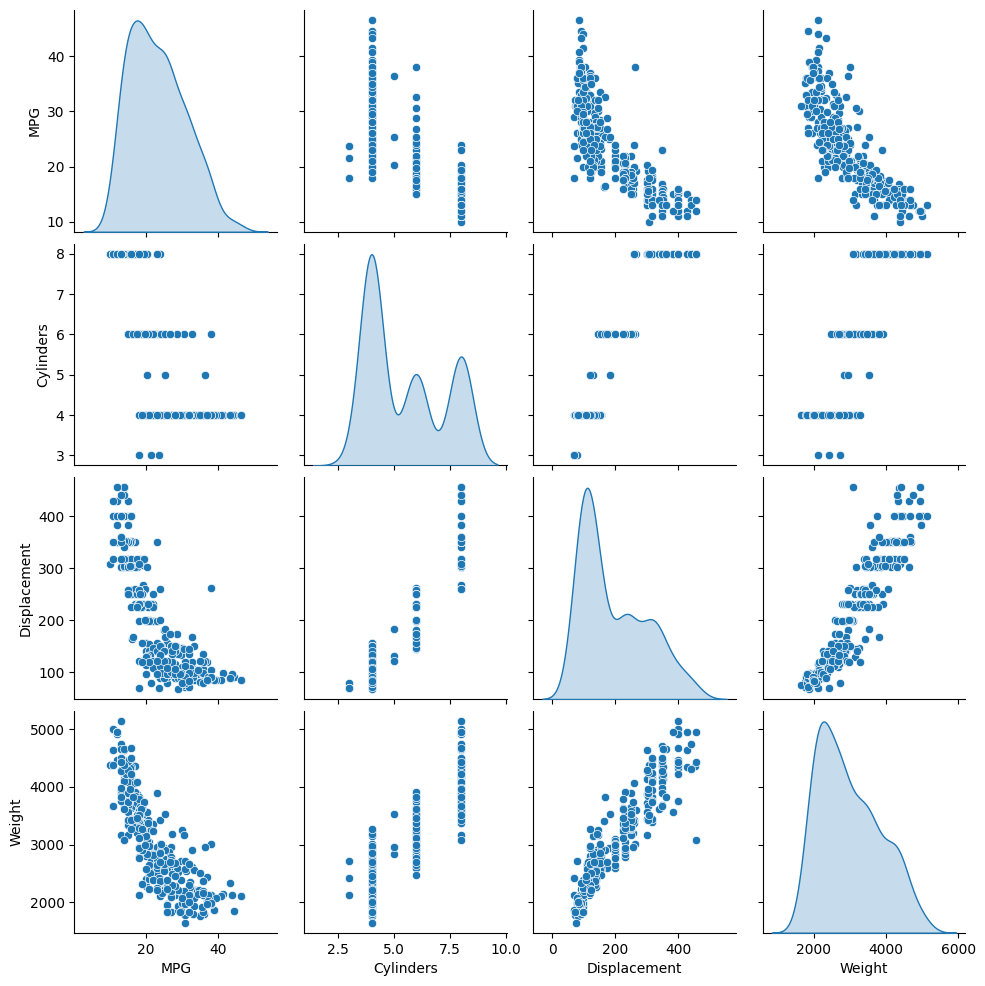

In [67]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

Давайте также проверим общую статистику. Обратите внимание, что каждая функция охватывает совершенно разный диапазон:

In [68]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0


### Отделение объектов от меток

Отделите целевое значение — «метку» — от функций. Эта метка представляет собой значение, которое вы научите модель прогнозировать.

In [69]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

## Нормализация

В таблице статистики легко увидеть, насколько различны диапазоны каждого признака:

In [70]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642


Хорошей практикой является нормализация функций, использующих разные масштабы и диапазоны.

Одна из причин, по которой это важно, заключается в том, что характеристики умножаются на веса модели. Таким образом, масштаб выходных данных и масштаб градиентов зависит от масштаба входных данных.

Хотя модель *может* сходиться без нормализации признаков, нормализация делает обучение намного более стабильным.



### Слой нормализации

«tf.keras.layers.Normalization» — это понятный и простой способ добавить нормализацию объектов в вашу модель.

Первым шагом является создание слоя:

In [71]:
normalizer = tf.keras.layers.Normalization(axis=-1)

Затем подгоните состояние слоя предварительной обработки к данным, вызвав «Normalization.adapt»:

In [72]:
normalizer.adapt(np.array(train_features))

Вычислите среднее значение и дисперсию и сохраните их в слое:

In [73]:
print(normalizer.mean.numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]]


При вызове слоя он возвращает входные данные, при этом каждый объект нормализуется независимо.:

In [74]:
first=np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  #print('Normalized:', normalizer(first).numpy())

First example: [[4 90.0 75.0 2125.0 14.5 74 False False True]]



## Линейная регрессия

Прежде чем строить модель глубокой нейронной сети, начните с линейной регрессии с использованием одной или нескольких переменных..

### Линейная регрессия с одной переменной

Начните с линейной регрессии с одной переменной, чтобы спрогнозировать «миль на галлон» по «лошадиной силе».

Обучение модели с помощью tf.keras обычно начинается с определения архитектуры модели. Используйте модель tf.keras.Sequential, которая [представляет собой последовательность шагов] (https://www.tensorflow.org/guide/keras/sequential_model).

В вашей модели линейной регрессии с одной переменной есть два шага:

- Нормализуйте входные характеристики «Horsepower» с помощью слоя предварительной обработки «tf.keras.layers.Normalization».
- Примените линейное преобразование ($y = mx+b$) для получения 1 результата с использованием линейного слоя (`tf.keras.layers.Dense`).

Количество _inputs_ можно установить либо с помощью аргумента `input_shape`, либо автоматически при первом запуске модели..### Линейная регрессия с одной переменной

Начните с линейной регрессии с одной переменной, чтобы спрогнозировать «миль на галлон» по «лошадиной силе».



Сначала создайте массив NumPy, состоящий из функций «Horsepower». Затем создайте экземпляр tf.keras.layers.Normalization и согласуйте его состояние с данными о лошадиных силах:

In [75]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Постройте последовательную модель Keras:

In [76]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization_3 (Normalization)      │ (None, 1)                   │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5 (24.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 3 (16.00 B)

Эта модель будет прогнозировать «миль на галлон» на основании «лошадиных сил».

Запустите необученную модель на первых 10 значениях «Лошадиные силы». Результат не будет хорошим, но обратите внимание, что он имеет ожидаемую форму `(10, 1)`:

In [77]:
horsepower_model.predict(horsepower[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


array([[-0.41 ],
       [-0.232],
       [ 0.757],
       [-0.575],
       [-0.52 ],
       [-0.204],
       [-0.616],
       [-0.52 ],
       [-0.136],
       [-0.232]], dtype=float32)

После построения модели настройте процедуру обучения, используя метод Keras Model.compile. Наиболее важными аргументами для компиляции являются `loss` и `optimizer`, поскольку они определяют, что будет оптимизировано (`mean_absolute_error`) и как (с использованием `tf.keras.optimizers.Adam`)..

In [78]:
horsepower_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

Используйте Keras `Model.fit` для выполнения обучения в течение 100 эпох:

In [79]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 14 s, sys: 438 ms, total: 14.5 s
Wall time: 27.4 s


Визуализируйте ход обучения модели, используя статистику, хранящуюся в объекте «история»:

In [80]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.802455,4.195864,95
96,3.802691,4.198951,96
97,3.803325,4.188874,97
98,3.806617,4.189415,98
99,3.802660,4.183369,99


In [81]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

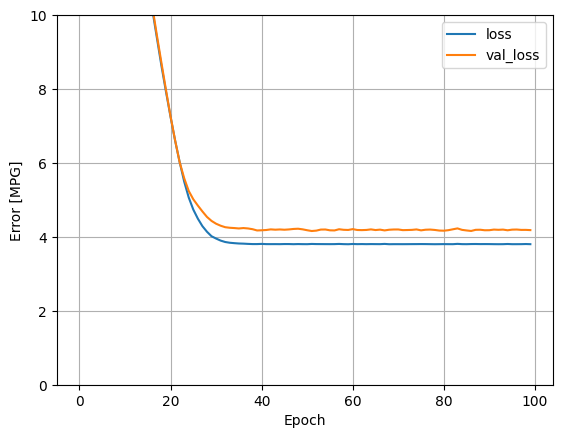

In [82]:
plot_loss(history)

Соберите результаты на тестовом наборе для последующего использования:

In [83]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

Поскольку это регрессия с одной переменной, прогнозы модели легко рассматривать как функцию входных данных:

In [84]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


In [85]:
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

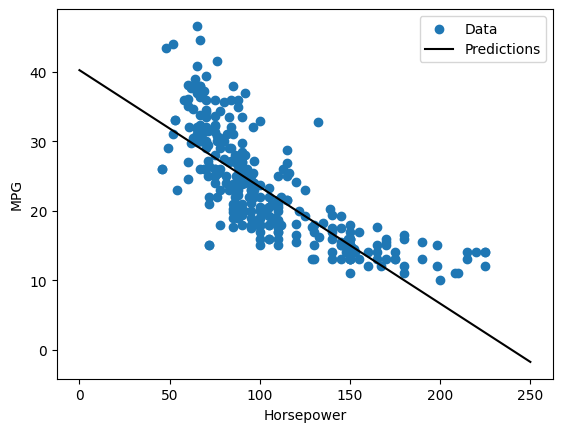

In [86]:
plot_horsepower(x, y)

### Линейная регрессия с несколькими входными данными

Вы можете использовать почти идентичную настройку, чтобы делать прогнозы на основе нескольких входных данных. Эта модель по-прежнему выполняет то же самое $y = mx+b$, за исключением того, что $m$ — матрица, а $b$ — вектор.

Снова создайте двухэтапную модель Keras Sequential, где первым слоем будет «нормализатор» (tf.keras.layers.Normalization(axis=-1)), который вы определили ранее и адаптировали ко всему набору данных.:

In [87]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

Когда вы вызываете Model.predict для пакета входных данных, он создает выходные данные units=1 для каждого примера.

In [88]:
linear_model.predict(train_features[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


array([[ 1.866],
       [ 0.549],
       [-0.475],
       [ 0.893],
       [-0.899],
       [ 0.156],
       [-0.836],
       [-0.667],
       [ 0.712],
       [-0.366]], dtype=float32)

Когда вы вызываете модель, ее весовые матрицы будут построены — убедитесь, что веса ядра ($m$ в $y=mx+b$) имеют форму `(9, 1)`:

In [89]:
linear_model.layers[1].kernel

<Variable path=sequential_5/dense_9/kernel, shape=(9, 1), dtype=float32, value=[[-0.469]
 [ 0.089]
 [-0.7  ]
 [-0.105]
 [-0.282]
 [-0.544]
 [ 0.203]
 [-0.073]
 [ 0.721]]>

Настройте модель с помощью Keras `Model.compile` и обучите с помощью `Model.fit` в течение 100 эпох:

In [90]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [91]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 11.6 s, sys: 449 ms, total: 12 s
Wall time: 14.9 s


Использование всех входных данных в этой регрессионной модели позволяет добиться гораздо меньшей ошибки обучения и проверки, чем в модели «horsepower_model», у которой был один вход:

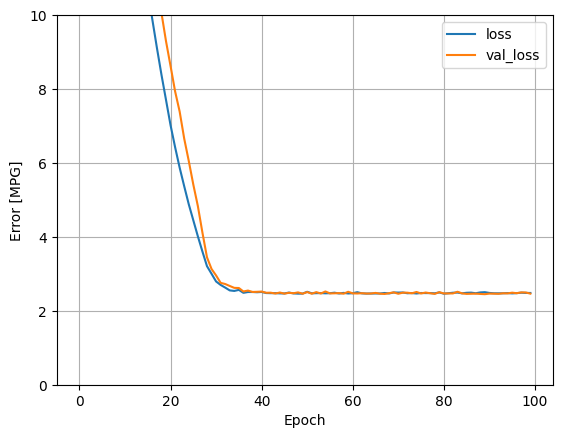

In [92]:
plot_loss(history)

Соберите результаты на тестовом наборе для последующего использования:

In [93]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

## Регрессия с помощью глубокой нейронной сети (DNN)

В предыдущем разделе вы реализовали две линейные модели для одного и нескольких входов.

Здесь вы будете реализовывать модели DNN с одним и несколькими входами.

Код в основном тот же, за исключением того, что модель расширена за счет включения некоторых «скрытых» нелинейных слоев. Название «скрытый» здесь просто означает отсутствие прямого подключения к входам или выходам..

Эти модели будут содержать на несколько больше слоев, чем линейная модель:

* Уровень нормализации, как и раньше (с «horsepower_normalizer» для модели с одним входом и «нормализатором» для модели с несколькими входами).
* Два скрытых, нелинейных, «Dense» слоя с нелинейностью функции активации ReLU («relu»).
* Линейный плотный слой с одним выходом.

Обе модели будут использовать одну и ту же процедуру обучения, поэтому метод компиляции включен в функцию build_and_compile_model ниже.

In [94]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

### Регрессия с использованием DNN и одного входного сигнала

Создайте модель DNN, используя только «Horsepower» в качестве входных данных и «horsepower_normalizer» (определенный ранее) в качестве слоя нормализации:

In [95]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

Эта модель имеет гораздо больше обучаемых параметров, чем линейные модели:

In [96]:
dnn_horsepower_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization_3 (Normalization)      │ (None, 1)                   │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,356 (17.02 KB)

 Trainable params: 4,353 (17.00 KB)

 Non-trainable params: 3 (16.00 B)

Train the model with Keras `Model.fit`:

In [97]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 13 s, sys: 586 ms, total: 13.6 s
Wall time: 16 s


Эта модель работает немного лучше, чем линейная «horsepower_model» с одним входом:

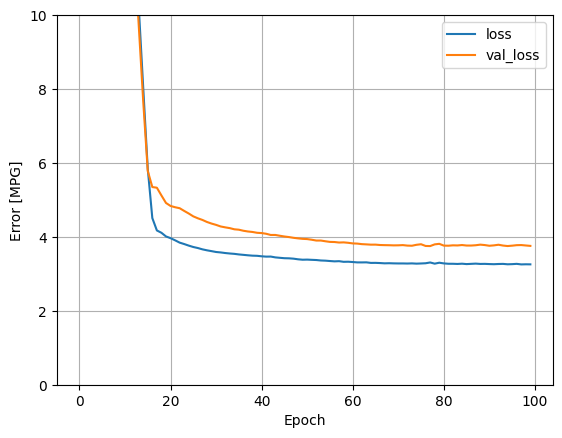

In [98]:
plot_loss(history)

Если вы построите прогнозы как функцию «Лошадиных сил», вы заметите, как эта модель использует преимущества нелинейности, обеспечиваемой скрытыми слоями.:

In [99]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


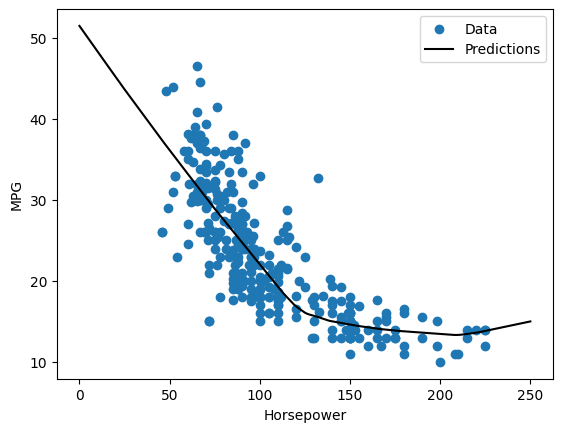

In [100]:
plot_horsepower(x, y)

Соберите результаты на тестовом наборе для последующего использования:

In [101]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

### Регрессия с использованием DNN и нескольких входных данных

Повторите предыдущий процесс, используя все входные данные. Производительность модели немного улучшается по сравнению с набором проверочных данных..

In [102]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization_2 (Normalization)      │ (10, 9)                     │              19 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19 (80.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 19 (80.00 B)

In [103]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 12.9 s, sys: 545 ms, total: 13.4 s
Wall time: 15.3 s


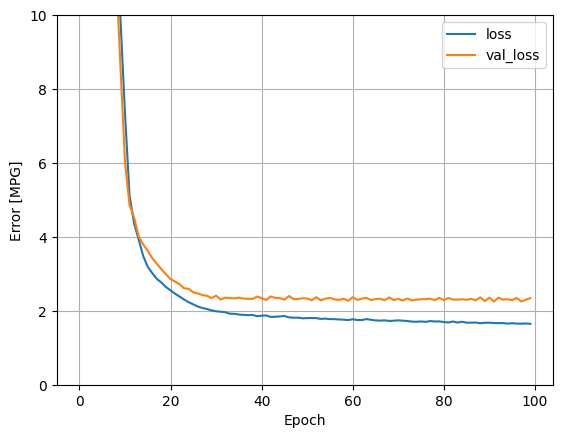

In [104]:
plot_loss(history)

Соберите результаты на тестовом наборе:

In [105]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

## Производительность

Поскольку все модели прошли обучение, вы можете просмотреть производительность их тестового набора:

In [106]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.636238
linear_model,2.465901
dnn_horsepower_model,2.922896
dnn_model,1.692505


Эти результаты соответствуют ошибке проверки, наблюдаемой во время обучения..

### Делайте прогнозы

Теперь вы можете делать прогнозы с помощью `dnn_model` в тестовом наборе, используя Keras `Model.predict` и просматривать потери:

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


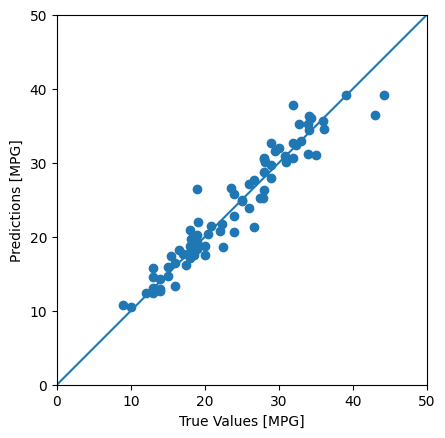

In [107]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


Похоже, что модель прогнозирует достаточно хорошо.

Теперь проверьте распределение ошибок:

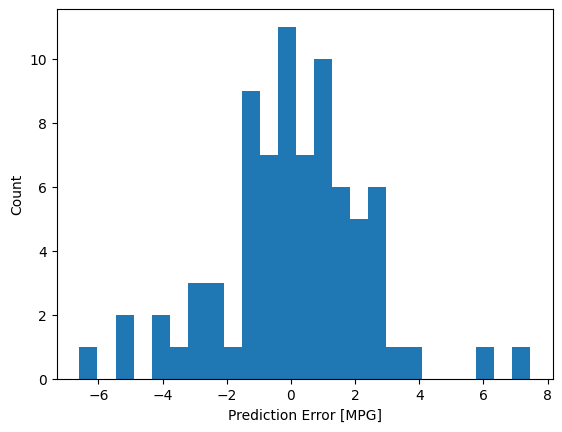

In [108]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

**ВНИМАНИЕ !! ЗАДАНИЕ **

**Ответьте на вопрос : Какая из моделей дает лучший результат. Поясните свой ответ**.

In [109]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.636238
linear_model,2.465901
dnn_horsepower_model,2.922896
dnn_model,1.692505


## Заключение

В этом файле представлено несколько методов решения проблемы регрессии. Вот еще несколько советов, которые могут помочь:

- Среднеквадратическая ошибка (MSE) (tf.keras.losses.MeanSquaredError) и средняя абсолютная ошибка (MAE) (tf.keras.losses.MeanAbsoluteError) — это распространенные функции потерь, используемые для задач регрессии. MAE менее чувствителен к выбросам. Для задач классификации используются различные функции потерь.
- Точно так же метрики оценки, используемые для регрессии, отличаются от классификации.
- Если функции числовых входных данных имеют значения в разных диапазонах, каждый объект должен масштабироваться независимо до одного и того же диапазона.
— Переобучение — распространенная проблема для моделей DNN, хотя в этом уроке это не проблема.